In [44]:
%%capture

!pip install seaborn yahooquery

import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from yahooquery import Ticker

warnings.filterwarnings('ignore')

In [45]:
#TOTAL INTERACTIONS AND ARTICLES PUBLISHED PER YEAR

#Import data
kw_2014 = pd.read_csv("Sustainability_Interest_Over_Time/Yearly_KW_Data/KW_2014.csv")
kw_2015 = pd.read_csv("Sustainability_Interest_Over_Time/Yearly_KW_Data/KW_2015.csv")
kw_2016 = pd.read_csv("Sustainability_Interest_Over_Time/Yearly_KW_Data/KW_2016.csv")
kw_2017 = pd.read_csv("Sustainability_Interest_Over_Time/Yearly_KW_Data/KW_2017.csv")
kw_2018 = pd.read_csv("Sustainability_Interest_Over_Time/Yearly_KW_Data/KW_2018.csv")
kw_2019 = pd.read_csv("Sustainability_Interest_Over_Time/Yearly_KW_Data/KW_2019.csv")
kw_2020 = pd.read_csv("Sustainability_Interest_Over_Time/Yearly_KW_Data/KW_2020.csv")
kw_2021 = pd.read_csv("Sustainability_Interest_Over_Time/Yearly_KW_Data/KW_2021.csv")
kw_2022 = pd.read_csv("Sustainability_Interest_Over_Time/Yearly_KW_Data/KW_2022.csv")
kw_2023 = pd.read_csv("Sustainability_Interest_Over_Time/Yearly_KW_Data/KW_2023.csv")

#Define cleaning function
def total(df,year):

    #Drop average interactions
    df.drop('Avg. Interactions',axis=1,inplace=True)

    #Object types in both columns are numbers separated by a ','. Removes the comma
    if df['Total Interactions'].dtype == 'O':
        df['Total Interactions'] = df['Total Interactions'].str.replace(',','')   
    if df['Article Count'].dtype == 'O':
        df['Article Count'] = df['Article Count'].str.replace(',','')

    #Converts data type and saves as complete dataframe
    df[['Article Count','Total Interactions']] = df[['Article Count','Total Interactions']].astype('int64')
    final = pd.DataFrame({'Year':[year],'Article Count':[df['Article Count'].sum()],'Interactions':[df['Total Interactions'].sum()]})
    return final

#Creates full, concatenated database
year_kw = pd.concat([total(kw_2014,2014),total(kw_2015,2015),total(kw_2016,2016),total(kw_2017,2017),total(kw_2018,2018),
                    total(kw_2019,2019),total(kw_2020,2020),total(kw_2021,2021),total(kw_2022,2022),total(kw_2023,2023)],axis=0,ignore_index=True)

#Save to csv
year_kw.to_csv("Sustainability_Interest_Over_Time/Yearly_KW_Data/Yearly_Keyword_Data.csv")

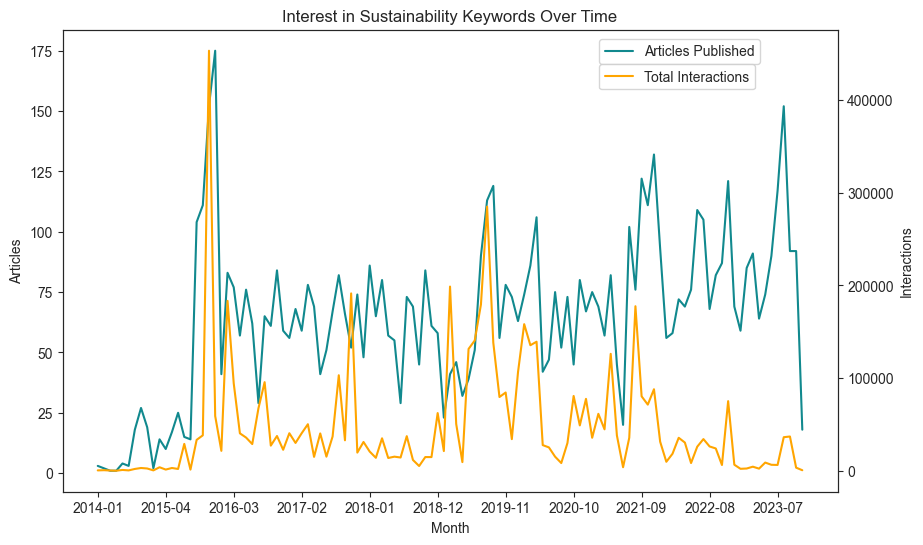

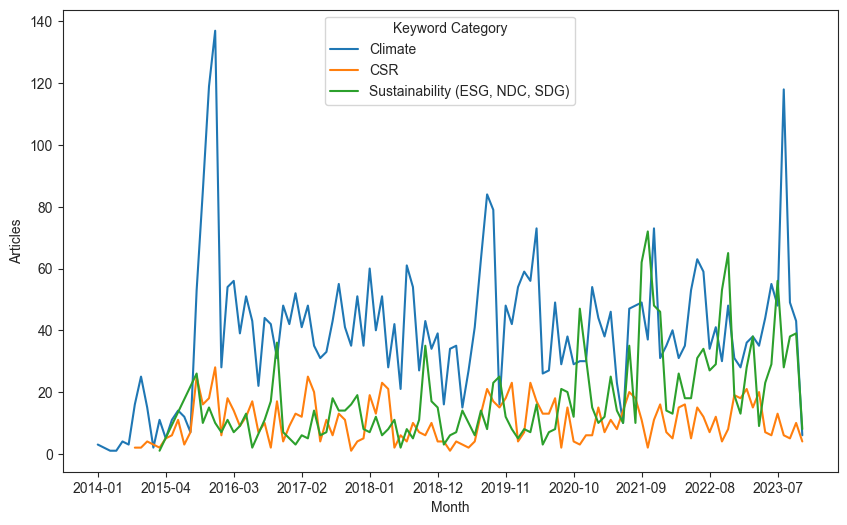

In [46]:
#TOTAL INTERACTIONS AND ARTICLES PUBLISHED PER MONTH

#Import data
mon_2014 = pd.read_excel("Sustainability_Interest_Over_Time/Monthly_KW_Data/2014.xlsx",header=0)
mon_2015 = pd.read_excel("Sustainability_Interest_Over_Time/Monthly_KW_Data/2015.xlsx",header=0)
mon_2016 = pd.read_excel("Sustainability_Interest_Over_Time/Monthly_KW_Data/2016.xlsx",header=0)
mon_2017 = pd.read_excel("Sustainability_Interest_Over_Time/Monthly_KW_Data/2017.xlsx",header=0)
mon_2018 = pd.read_excel("Sustainability_Interest_Over_Time/Monthly_KW_Data/2018.xlsx",header=0)
mon_2019 = pd.read_excel("Sustainability_Interest_Over_Time/Monthly_KW_Data/2019.xlsx",header=0)
mon_2020 = pd.read_excel("Sustainability_Interest_Over_Time/Monthly_KW_Data/2020.xlsx",header=0)
mon_2021 = pd.read_excel("Sustainability_Interest_Over_Time/Monthly_KW_Data/2021.xlsx",header=0)
mon_2022 = pd.read_excel("Sustainability_Interest_Over_Time/Monthly_KW_Data/2022.xlsx",header=0)
mon_2023 = pd.read_excel("Sustainability_Interest_Over_Time/Monthly_KW_Data/2023.xlsx",header=0)

#Define data wrangling function
def wrangle(df):

    #Drops columns
    df.drop(['Link','Authors','Pinterest','LinkedIn','Twitter Influencer Shares','Total Facebook','Likes','Shares','Comments'],axis=1,inplace=True)

    #Converts published column to datetime format and converts article title to lowercase
    df['Published'] = pd.to_datetime(df['Published'],format='%Y-%m-%dT%H:%M:%S%z')
    df['Headline'] = df['Headline'].str.lower()

    #Renames and reorders columns
    df = df.rename(columns={'Published':'Date','Group':'Keyword','Headline':'Title','Total Interactions':'Interactions'})
    df = df.reindex(columns=['Date','Month','Keyword','Title','Website','Interactions'])

    #Extracts the month from the date column
    df['Month'] = df['Date'].dt.to_period('M')
    df['Month'] = df['Month'].astype('str')
    return df

#Concatenates wrangled data
mon_kw = pd.concat([wrangle(mon_2014),wrangle(mon_2015),wrangle(mon_2016),wrangle(mon_2017),wrangle(mon_2018),
                   wrangle(mon_2019),wrangle(mon_2020),wrangle(mon_2021),wrangle(mon_2022),wrangle(mon_2023)],axis=0,ignore_index=True)

#Categorizes keywords to increase visibility and isolate CSR
def kw_categorize(keyword):
    if keyword in ['Climate Change','Global Warming','Greenhouse gas','Pollution']:
        return 'Climate'
    elif keyword == 'CSR':
        return 'CSR'
    elif keyword in ['ESG','NDC','SDG']:
        return 'Sustainability (ESG, NDC, SDG)'

#Runs the categorize function on the keyword column and appends a new column containing the category
mon_kw['Keyword Category'] = mon_kw['Keyword'].apply(kw_categorize)

#Reindex and save to csv
mon_kw = mon_kw.reindex(columns=['Date','Month','Keyword','Keyword Category','Title','Website','Interactions'])
mon_kw.to_csv("Sustainability_Interest_Over_Time/Monthly_KW_Data/Monthly_Keyword_Data.csv")

#Total articles published vs total interactions visualization
forviz = mon_kw[['Month','Keyword','Interactions']].groupby(['Month']).agg({'Keyword':'count','Interactions':'sum'}).rename(columns={'Keyword':'Articles'})
forviz.reset_index(inplace=True)
plt.figure(figsize=(10,6))
sns.set_style('ticks')
sns.lineplot(data=forviz,x='Month',y='Articles',label='Articles Published',color='#11898E')
plt.legend(loc='upper right',bbox_to_anchor=(1-0.1,0.98),borderaxespad=0.,alignment='left')
ax2 = plt.twinx()
sns.lineplot(data=forviz,x='Month',y='Interactions',label='Total Interactions',color='orange')
plt.legend(loc='upper right',bbox_to_anchor=(0.993-0.1,0.925),borderaxespad=0.,alignment='left')
ax1 = plt.gca()
ax2.set_xticks(forviz['Month'].tolist()[0::11])
ax1.set_ylabel("# of Articles")
ax2.set_ylabel("Interactions")
plt.title('Interest in Sustainability Keywords Over Time')

#Articles published based on keyword visualization
keywordz = mon_kw[['Month','Keyword Category','Title']].groupby(['Month','Keyword Category']).count().rename(columns={'Title':'Articles'})
keywordz.reset_index(inplace=True)
plt.figure(figsize=(10,6))
sns.set_style('ticks')
sns.lineplot(data=keywordz,x='Month',y='Articles',hue='Keyword Category').set_xticks(forviz['Month'].tolist()[0::11])
ax2.set_xticks(forviz['Month'].tolist()[0::11])

plt.show()

In [70]:
#STEP 1: PULL TICKER SYMBOLS OF TOP 50 COMPANIES
big50_ticks = [x+'.JK' for x in list(pd.read_excel("Indo_50_Biggest_Companies.xlsx",sheet_name="50 Biggest Market Capitalizatio",\
            header=3,nrows=51,usecols=[2])['Code'])[1:]]

#STEP 2: FILL DATAFRAME WITH COLUMNS STRUCTURED AS 1. COMPANY NAME 2. REVENUE PER SHARE 3. TOTAL ESG RATING
BCA = Ticker("BBCA.JK")
print(BCA.financial_data['BBCA.JK']['revenuePerShare'])
print(BCA.esg_scores['BBCA.JK']['totalEsg'])

['BBCA.JK',
 'BBRI.JK',
 'BREN.JK',
 'BYAN.JK',
 'BMRI.JK',
 'AMMN.JK',
 'TLKM.JK',
 'TPIA.JK',
 'ASII.JK',
 'BBNI.JK',
 'UNVR.JK',
 'ICBP.JK',
 'AMRT.JK',
 'HMSP.JK',
 'BRPT.JK',
 'CPIN.JK',
 'UNTR.JK',
 'SMMA.JK',
 'DCII.JK',
 'ADRO.JK',
 'KLBF.JK',
 'ISAT.JK',
 'MBMA.JK',
 'GOTO.JK',
 'BRIS.JK',
 'DNET.JK',
 'MEGA.JK',
 'MYOR.JK',
 'NCKL.JK',
 'CUAN.JK',
 'PANI.JK',
 'PGEO.JK',
 'INDF.JK',
 'BELI.JK',
 'MDKA.JK',
 'INKP.JK',
 'MTEL.JK',
 'INCO.JK',
 'TBIG.JK',
 'TOWR.JK',
 'ADMR.JK',
 'GGRM.JK',
 'TCPI.JK',
 'BNGA.JK',
 'BUMI.JK',
 'SMGR.JK',
 'ANTM.JK',
 'DSSA.JK',
 'MIKA.JK',
 'SUPR.JK']

778.115
25.86
